# REINFORCE

play atari-pong use REINFORCE

- REINFORCE objective function:
\begin{equation}
L(\theta)
=\sum_{t=0}^T \log\pi_{\theta}(a_t|s_t)\hat{Q}(s_t,a_t)
\end{equation}

In [2]:
# upgrade pytorch
#!pip install --upgrade torch

In [1]:
import gym

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## 1. explore the evnironment

In [2]:
env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
RIGHT = 4
LEFT = 5

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [3]:
def preprocess_frames(frame_list, bkg_color = np.array([144, 72, 17])):
    x = np.asarray(frame_list)[:,34:-16:2,::2,:]-bkg_color
    x = np.mean(x, axis=-1)/255.
    return x[np.newaxis,:,:,:]

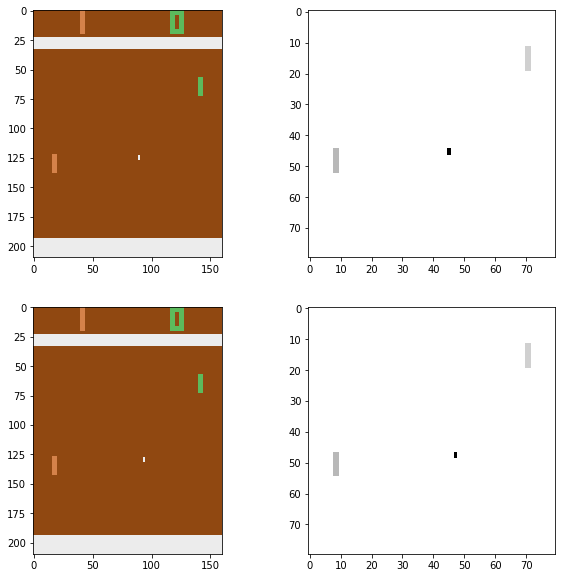

In [4]:
env.reset()
env.step(1)
for _ in range(40):
    fr1, re1, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
    fr2, re2, _, _ = env.step(0)


state, reward, done, _ = env.step(np.random.choice([RIGHT,LEFT]))
frame = preprocess_frames([state])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(221)
ax.imshow(state)

ax = fig.add_subplot(222)
ax.imshow(frame[0][0], cmap='Greys')


state, reward, done, _ = env.step(np.random.choice([RIGHT,LEFT]))
frame = preprocess_frames([state])

ax = fig.add_subplot(223)
ax.imshow(state)

ax = fig.add_subplot(224)
ax.imshow(frame[0][0], cmap='Greys')

plt.show()

In [5]:
## we take one action and skip game forward, (0=no action)
# stack two frames as one input to the network
fr1, re1, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
fr2, re2, _, _ = env.step(0)

frame = preprocess_frames([fr1 , fr2])
frame.shape

(1, 2, 80, 80)

In [6]:
env.close()

## 2. parallel environment

slightly adjust the preprocess function for the parallel environment

In [7]:
from parallelEnv import parallelEnv
envs = parallelEnv('PongDeterministic-v4', n = 8, seed = 1234)
n = len(envs.ps)

In [8]:
def preprocess_frames_batch(frame_list, bkg_color = np.array([144, 72, 17])):
    x = np.asarray(frame_list)[:,:,34:-16:2,::2,:]-bkg_color
    x = np.mean(x, axis=-1)/255.
    return np.swapaxes(x,0,1) 

In [9]:
envs.reset()
envs.step([1]*n)
for _ in range(20):
    fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
    fr2, re2, _, _ = envs.step([0]*n)

state = preprocess_frames_batch([fr1 , fr2])
state.shape

(8, 2, 80, 80)

In [10]:
class Policy(nn.Module):
    def __init__(self, action_size = 2):
        super(Policy, self).__init__()
        self.main= nn.Sequential(
            # (:,2,80,80) to (:,4,38,38)
            nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False),
            nn.ReLU(inplace = True),
            # (:,4,38,38) to (:,16,9,9)
            nn.Conv2d(4, 16, kernel_size=6, stride=4),
            nn.ReLU(inplace = True),
            nn.Flatten(),

            nn.Linear(9*9*16, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, action_size),

            nn.Softmax(dim = 1)
        )

    def forward(self, state):
        return self.main(state)
    
def act(policy, state):
    state = torch.from_numpy(state).float().to(device)
    probs = policy(state).cpu()
    m = Categorical(probs)
    action = m.sample() 
    log_prob =  m.log_prob(action)
    return action + 4, log_prob 

## 3. start training

In [11]:
def collect_trajectories(envs, policy, tmax):
    # collect trajectories for a parallelized parallelEnv object
    n=len(envs.ps)
    policy.eval()
    
    reward_list, log_prob_list = [], []
    
    # initialize
    fr1 = envs.reset()
    fr2, _, _, _ = envs.step([1]*n)
    for t in range(tmax):
        state = preprocess_frames_batch([fr1 , fr2])
        action, log_prob = act(policy, state)
        fr1, re1, done, _ = envs.step(action.numpy())
        if done.any():
            break
        fr2, re2, done, _ = envs.step([0]*n)
        if done.any():
            break
            
        reward_list.append(re1 + re2)
        log_prob_list.append(log_prob)

    return reward_list, log_prob_list


def r2g(reward_list, gamma):
    """compute normalized sum of discounted rewards to go """
    reward_array = np.asarray(reward_list)
    T = len(reward_list)
    R = []
    for t in range(T):
        # sum of discounted rewards to go
        discounts = gamma**np.arange(T-t)
        reward_to_go = reward_array[t:,:]*discounts[:,np.newaxis]
        sum_of_rewards = reward_to_go.sum(axis = 0) # sum of steps
        # normalization
        mean, std= np.mean(sum_of_rewards), np.std(sum_of_rewards) + 1.0e-10
        normalized = (sum_of_rewards - mean)/std
        R.append(torch.from_numpy(normalized).float().view(1,-1))
    return torch.cat(R)

In [12]:
envs = parallelEnv('PongDeterministic-v4', n = 8, seed = 1234)

TMAX = 320
NUM_EPISODES = 100
PRINT_EVERY = 10
GAMMA = 0.99

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = 1e-2, weight_decay = 0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.1)

score_list = []
for e in range(1, NUM_EPISODES+1):
    # collect a trajectory
    reward_list, log_prob_list = collect_trajectories(envs, policy, tmax = TMAX)
    policy.train()
    
    score_batch = np.sum(reward_list, axis=0)
    score = np.mean(score_batch)
    score_list.append(score) 
    print('\rEpisode {}...sum of rewards {:6.2f}.....'.format(e, score), end = "")
            
    # compute loss
    R_tensor = r2g(reward_list, gamma = GAMMA).to(device) # no grad
    logp_tensor = torch.cat([logp.view(1,-1) for logp in log_prob_list]).to(device) # has grad
    L = -logp_tensor*R_tensor
    loss = L.sum(dim = 0).mean() # sum over steps; average over batches
    
    # update network 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}...sum of rewards {:6.2f}.....'.format(e, score))
        scheduler.step()


Episode 10...sum of rewards -14.62.....
Episode 20...sum of rewards -14.00.....
Episode 30...sum of rewards -12.12.....
Episode 40...sum of rewards  -8.75.....
Episode 50...sum of rewards  -6.00.....
Episode 60...sum of rewards  -7.12.....
Episode 70...sum of rewards  -5.00.....
Episode 80...sum of rewards  -6.38.....
Episode 90...sum of rewards  -2.88.....
Episode 100...sum of rewards  -3.88.....


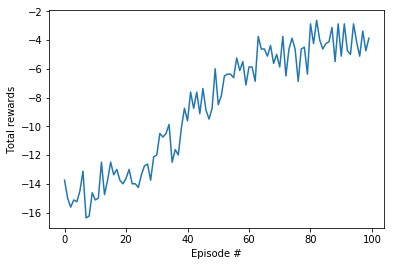

In [13]:
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.show()

In [14]:
envs.close()